## Подготовка

### Зависимости

Загрузка зависимостей:

In [1]:
# Установка зависимостей, необходимых для предобработки текста
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.3MB 9.9MB/s 


In [2]:
# Установка оптимизатора
!pip install -q tf-models-official

     |████████████████████████████████| 1.6MB 12.5MB/s 
     |████████████████████████████████| 1.2MB 49.3MB/s 
     |████████████████████████████████| 358kB 49.4MB/s 
     |████████████████████████████████| 215kB 48.0MB/s 
     |████████████████████████████████| 645kB 50.9MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 37.2MB 84kB/s 
     |████████████████████████████████| 686kB 36.3MB/s 


Импорт зависимостей:

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

### Загрузка данных

Для анализа используется [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/), содержащий 50000 обзоров на фильмы из [Internet Movie Database](https://www.imdb.com/).

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# Удаление неиспользуемых файлов
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 2s 0us/step


Разделение датасета на **тренировочную** и **валидационную** выборки:

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42 # Фиксирование сида, для того, чтобы при разделении наблюдения не перескались

# Создание тренировочного датасета
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Создание валидационного датасета
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Тестовый датасет
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Загрузка предобработчика

In [6]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [7]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Пример работы предобработчика:

In [8]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### Загрузка модели

In [9]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [10]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999945   0.14341958 -0.998978    0.9951448  -0.9997457   0.9131291
 -0.9961581  -0.9709751   0.09740017  0.01907067 -0.84881747 -0.09385538]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-0.43723646 -1.0138294  -2.3744745  ... -0.7589707  -2.0910308
  -0.2580993 ]
 [-1.3369722  -0.3688021   0.57868814 ... -2.1810174  -1.7530917
  -0.09555025]
 [-1.0607057  -0.30371028  0.34461355 ... -1.2898579  -1.9519887
  -0.12230396]
 ...
 [-0.86022747 -0.5440611   0.65837383 ... -1.4765673  -1.751861
   1.1197373 ]
 [-0.4686907  -0.5715229   0.67256635 ... -1.7302344  -1.9740777
   0.97479236]
 [ 0.02036649 -0.7551187   0.5948246  ... -1.965678   -1.9051421
   0.48970145]]


## Создание и обучение модели

### Определение модели

In [11]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [12]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.61353105]], shape=(1, 1), dtype=float32)


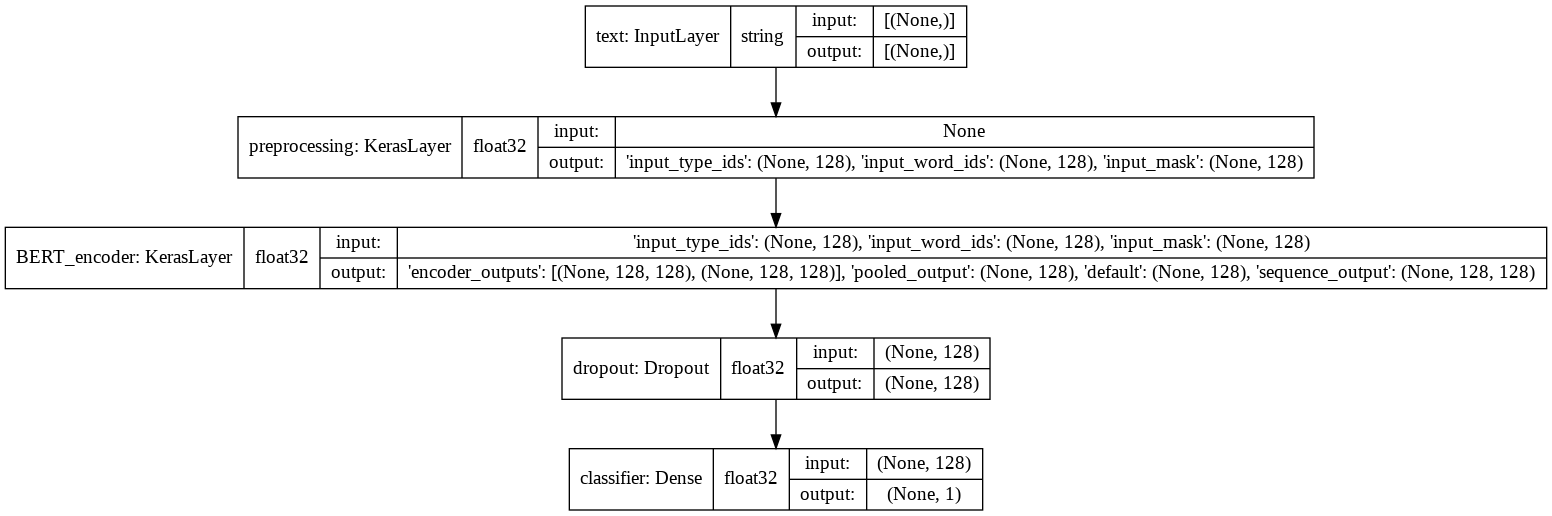

In [25]:
tf.keras.utils.plot_model(classifier_model, show_shapes=True, show_dtype=True,
    show_layer_names=True, expand_nested=False)

### Обучение модели

#### Опеределение параметров

Опредление функции потерь и метрики:

In [14]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

Определение метода оптимизации градиентного спуска:

In [15]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

#### Обучение

Копмилирование модели:

In [16]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Запуск обучения:

In [17]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/5
625/625 [==============================] - 68s 104ms/step - loss: 0.6413 - binary_accuracy: 0.5998 - val_loss: 0.5125 - val_binary_accuracy: 0.7274
Epoch 2/5
625/625 [==============================] - 62s 99ms/step - loss: 0.4860 - binary_accuracy: 0.7537 - val_loss: 0.4458 - val_binary_accuracy: 0.7862
Epoch 3/5
625/625 [==============================] - 61s 98ms/step - loss: 0.4332 - binary_accuracy: 0.7922 - val_loss: 0.4322 - val_binary_accuracy: 0.7962
Epoch 4/5
625/625 [==============================] - 61s 98ms/step - loss: 0.4106 - binary_accuracy: 0.8084 - val_loss: 0.4269 - val_binary_accuracy: 0.8018
Epoch 5/5
625/625 [==============================] - 61s 97ms/step - loss: 0.3956 - binary_accuracy: 0.8195 - val_loss: 0.4262 - val_binary_accuracy: 0.8030


#### Оценка модели

In [18]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 54s 69ms/step - loss: 0.4287 - binary_accuracy: 0.8022
Loss: 0.42868906259536743
Accuracy: 0.8021600246429443


График функции потерь:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


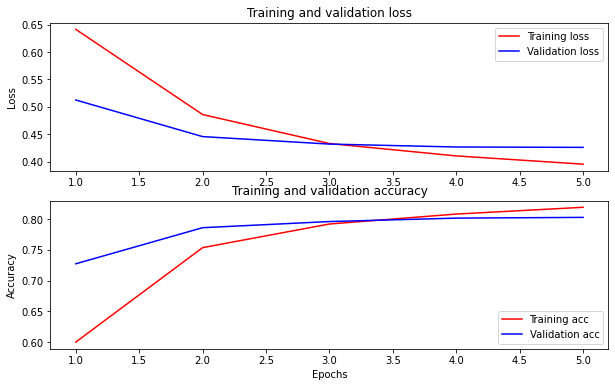

In [19]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')